In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
%matplotlib inline

# 닉네임, 토큰 설정
# os.environ["KAGGLE_USERNAME"] = ''
# os.environ["KAGGLE_KEY"] = ""

# 데이터 받기, colab에서 리눅스 명령어를 사용할때는 앞에 !가 붙습니다.
!kaggle competitions download -c titanic

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 2.55MB/s]


In [2]:
!unzip -o titanic.zip
!rm titanic.zip
!ls -al

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
total 4212
drwxr-xr-x 12 jovyan users     384 Jun  6 11:52  .
drwsrwsr-x  1 jovyan users    4096 Jun  4 18:20  ..
-rw-r--r--  1 jovyan users   36025 Jun  5 06:04 'Accuracy 100%.ipynb'
-rw-r--r--  1 jovyan users    3258 Dec 11  2019  gender_submission.csv
drwxr-xr-x  6 jovyan users     192 Jun  5 06:07  .ipynb_checkpoints
-rw-r--r--  1 jovyan users  925004 Jun  6 11:51 'Random Forest.ipynb'
-rw-r--r--  1 jovyan users    1523 Jun  5 06:04  result.csv
-rw-r--r--  1 jovyan users    2839 Jun  6 11:50  submission.csv
-rw-r--r--  1 jovyan users   28629 Dec 11  2019  test.csv
-rw-r--r--  1 jovyan users 1275563 May 21 07:18  Titanic.ipynb
-rw-r--r--  1 jovyan users 1959664 Jun  4 16:33 'Titanic Preprocessing and Decision Tree.ipynb'
-rw-r--r--  1 jovyan users   61194 Dec 11  2019  train.csv


In [3]:
df = pd.read_csv('./train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.loc[df['Age'].isnull(), 'Age'] = math.floor(df['Age'].mean())

In [5]:
df.loc[ df['Age'] <= 10, 'Age_clean'] = 0
df.loc[(df['Age'] > 10) & (df['Age'] <= 16), 'Age_clean'] = 1
df.loc[(df['Age'] > 16) & (df['Age'] <= 20), 'Age_clean'] = 2
df.loc[(df['Age'] > 20) & (df['Age'] <= 26), 'Age_clean'] = 3
df.loc[(df['Age'] > 26) & (df['Age'] <= 30), 'Age_clean'] = 4
df.loc[(df['Age'] > 30) & (df['Age'] <= 36), 'Age_clean'] = 5
df.loc[(df['Age'] > 36) & (df['Age'] <= 40), 'Age_clean'] = 6
df.loc[(df['Age'] > 40) & (df['Age'] <= 46), 'Age_clean'] = 7
df.loc[(df['Age'] > 46) & (df['Age'] <= 50), 'Age_clean'] = 8
df.loc[(df['Age'] > 50) & (df['Age'] <= 60), 'Age_clean'] = 9
df.loc[ df['Age'] > 60, 'Age_clean'] = 10

In [6]:
df.loc[df['Embarked'].isnull(), 'Embarked'] = df['Embarked'].mode()[0]

In [7]:
df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search('Z' if pd.isna(x) else x).group())

In [8]:
df['Fare_remainder_by_10'] = df['Fare'] - (df['Fare'] % 10)
df['Age_remainder_by_10'] = df['Age'] - (df['Age'] % 10)

In [9]:
def getNameTitle(name):
    reCom = re.compile("(M(?:is)?s|(?:Mrs?))|M(?:aster)").search(name)
    if reCom is not None:
        return reCom.group()
    return 'Others'

In [10]:
df['Title'] = df['Name'].replace('Mlle', 'Miss')
df['Title'] = df['Name'].replace('Ms', 'Miss')
df['Title'] = df['Name'].replace('Mme', 'Mrs')

In [11]:
df['Name_title'] = df['Title'].map(lambda x: getNameTitle(x))

In [12]:
df['Name_title'].value_counts()

Mr        518
Miss      182
Mrs       127
Master     40
Others     23
Ms          1
Name: Name_title, dtype: int64

In [13]:
df['Fare_per_person'] = df['Fare'] / (df['SibSp'] + df['Parch'] + 1)

In [14]:
df['Fare_per_person_remainder_by_10'] = df['Fare_per_person'] - (df['Fare_per_person'] % 10)

In [15]:
df['is_alone'] = 1
df.loc[df['SibSp'] + df['Parch'] > 0, 'is_alone'] = 0

In [16]:
df['is_pclass_3_from_queenstown'] = 0
df.loc[(df['Pclass'] == 3) & (df['Embarked'] == 'Q'), 'is_pclass_3_from_queenstown'] = 1

In [17]:
df['is_pclass_3_from_southampton'] = 0
df.loc[(df['Pclass'] == 3) & (df['Embarked'] == 'S'), 'is_pclass_3_from_southampton'] = 1

In [18]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [19]:
deckDummies = pd.get_dummies(df['Deck'], prefix='Deck')
sexDummies = pd.get_dummies(df['Sex'])
embarkedDummies = pd.get_dummies(df['Embarked'])
nameTitleDummies = pd.get_dummies(df['Name_title'])

In [20]:
df = pd.concat([df, deckDummies, sexDummies, embarkedDummies, nameTitleDummies], axis=1)
df = df.drop(['Sex', 'Embarked'], axis=1)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean,Deck,Fare_remainder_by_10,...,male,C,Q,S,Master,Miss,Mr,Mrs,Ms,Others
0,1,0,3,22.0,1,0,7.2500,3.0,Z,0.0,...,1,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,71.2833,6.0,C,70.0,...,0,1,0,0,0,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,3.0,Z,0.0,...,0,0,0,1,0,1,0,0,0,0
3,4,1,1,35.0,1,0,53.1000,5.0,C,50.0,...,0,0,0,1,0,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,5.0,Z,0.0,...,1,0,0,1,0,0,1,0,0,0


In [21]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_clean', 'Deck', 'Fare_remainder_by_10', 'Age_remainder_by_10',
       'Title', 'Name_title', 'Fare_per_person',
       'Fare_per_person_remainder_by_10', 'is_alone',
       'is_pclass_3_from_queenstown', 'is_pclass_3_from_southampton', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Deck_Z', 'female', 'male', 'C', 'Q', 'S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Ms', 'Others'],
      dtype='object')

In [22]:
cols = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_clean', 'Fare_remainder_by_10', 'Age_remainder_by_10', 'Fare_per_person',
       'Fare_per_person_remainder_by_10', 'is_alone',
       'is_pclass_3_from_queenstown', 'is_pclass_3_from_southampton', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 
       'Deck_Z', 'female', 'male', 'C', 'Q', 'S', 'Master', 'Miss', 'Mr',
       'Mrs', 'Ms', 'Others']

In [23]:
dfCorr = df.corr()
dfCorr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean,Fare_remainder_by_10,Age_remainder_by_10,...,male,C,Q,S,Master,Miss,Mr,Mrs,Ms,Others
PassengerId,1.000000,-0.005007,-0.035144,0.033632,-0.057527,-0.001652,0.012658,0.037706,0.012478,0.037231,...,0.042939,-0.001205,-0.033606,0.022204,-0.026151,-0.073110,0.040227,0.015864,-0.000261,0.059958
Survived,-0.005007,1.000000,-0.338481,-0.067814,-0.035322,0.081629,0.257307,-0.054064,0.262167,-0.050972,...,-0.543351,0.168240,0.003650,-0.149683,0.085221,0.327093,-0.546521,0.344935,0.042470,-0.012054
Pclass,-0.035144,-0.338481,1.000000,-0.334974,0.083081,0.018443,-0.549500,-0.341465,-0.564862,-0.339610,...,0.131900,-0.243292,0.221009,0.074053,0.082081,-0.000576,0.139188,-0.158279,-0.012381,-0.187174
Age,0.033632,-0.067814,-0.334974,1.000000,-0.232978,-0.176486,0.093706,0.985721,0.096364,0.971893,...,0.082949,0.031303,-0.021093,-0.014149,-0.376027,-0.247796,0.187335,0.169894,-0.004024,0.164506
SibSp,-0.057527,-0.035322,0.083081,-0.232978,1.000000,0.414838,0.159651,-0.223713,0.157098,-0.226973,...,-0.114631,-0.059528,-0.026354,0.068734,0.349559,0.087932,-0.249598,0.062854,-0.015907,-0.038717
Parch,-0.001652,0.081629,0.018443,-0.176486,0.414838,1.000000,0.216225,-0.157569,0.220385,-0.158376,...,-0.245489,-0.011069,-0.081228,0.060814,0.267344,0.105567,-0.335107,0.221318,-0.015878,-0.059535
Fare,0.012658,0.257307,-0.549500,0.093706,0.159651,0.216225,1.000000,0.096051,0.998423,0.099775,...,-0.182333,0.269335,-0.117216,-0.162184,0.010908,0.118271,-0.182702,0.106104,-0.012961,0.022270
Age_clean,0.037706,-0.054064,-0.341465,0.985721,-0.223713,-0.157569,0.096051,1.000000,0.098802,0.967214,...,0.077639,0.023907,-0.030382,-0.001825,-0.343214,-0.250256,0.166612,0.179725,-0.002755,0.170440
Fare_remainder_by_10,0.012478,0.262167,-0.564862,0.096364,0.157098,0.220385,0.998423,0.098802,1.000000,0.102177,...,-0.185802,0.265629,-0.123516,-0.154973,0.010492,0.119260,-0.187728,0.110161,-0.011038,0.026589
Age_remainder_by_10,0.037231,-0.050972,-0.339610,0.971893,-0.226973,-0.158376,0.099775,0.967214,0.102177,1.000000,...,0.074794,0.030254,-0.063081,0.013193,-0.339213,-0.231243,0.161095,0.162347,-0.010408,0.173969


<AxesSubplot:>

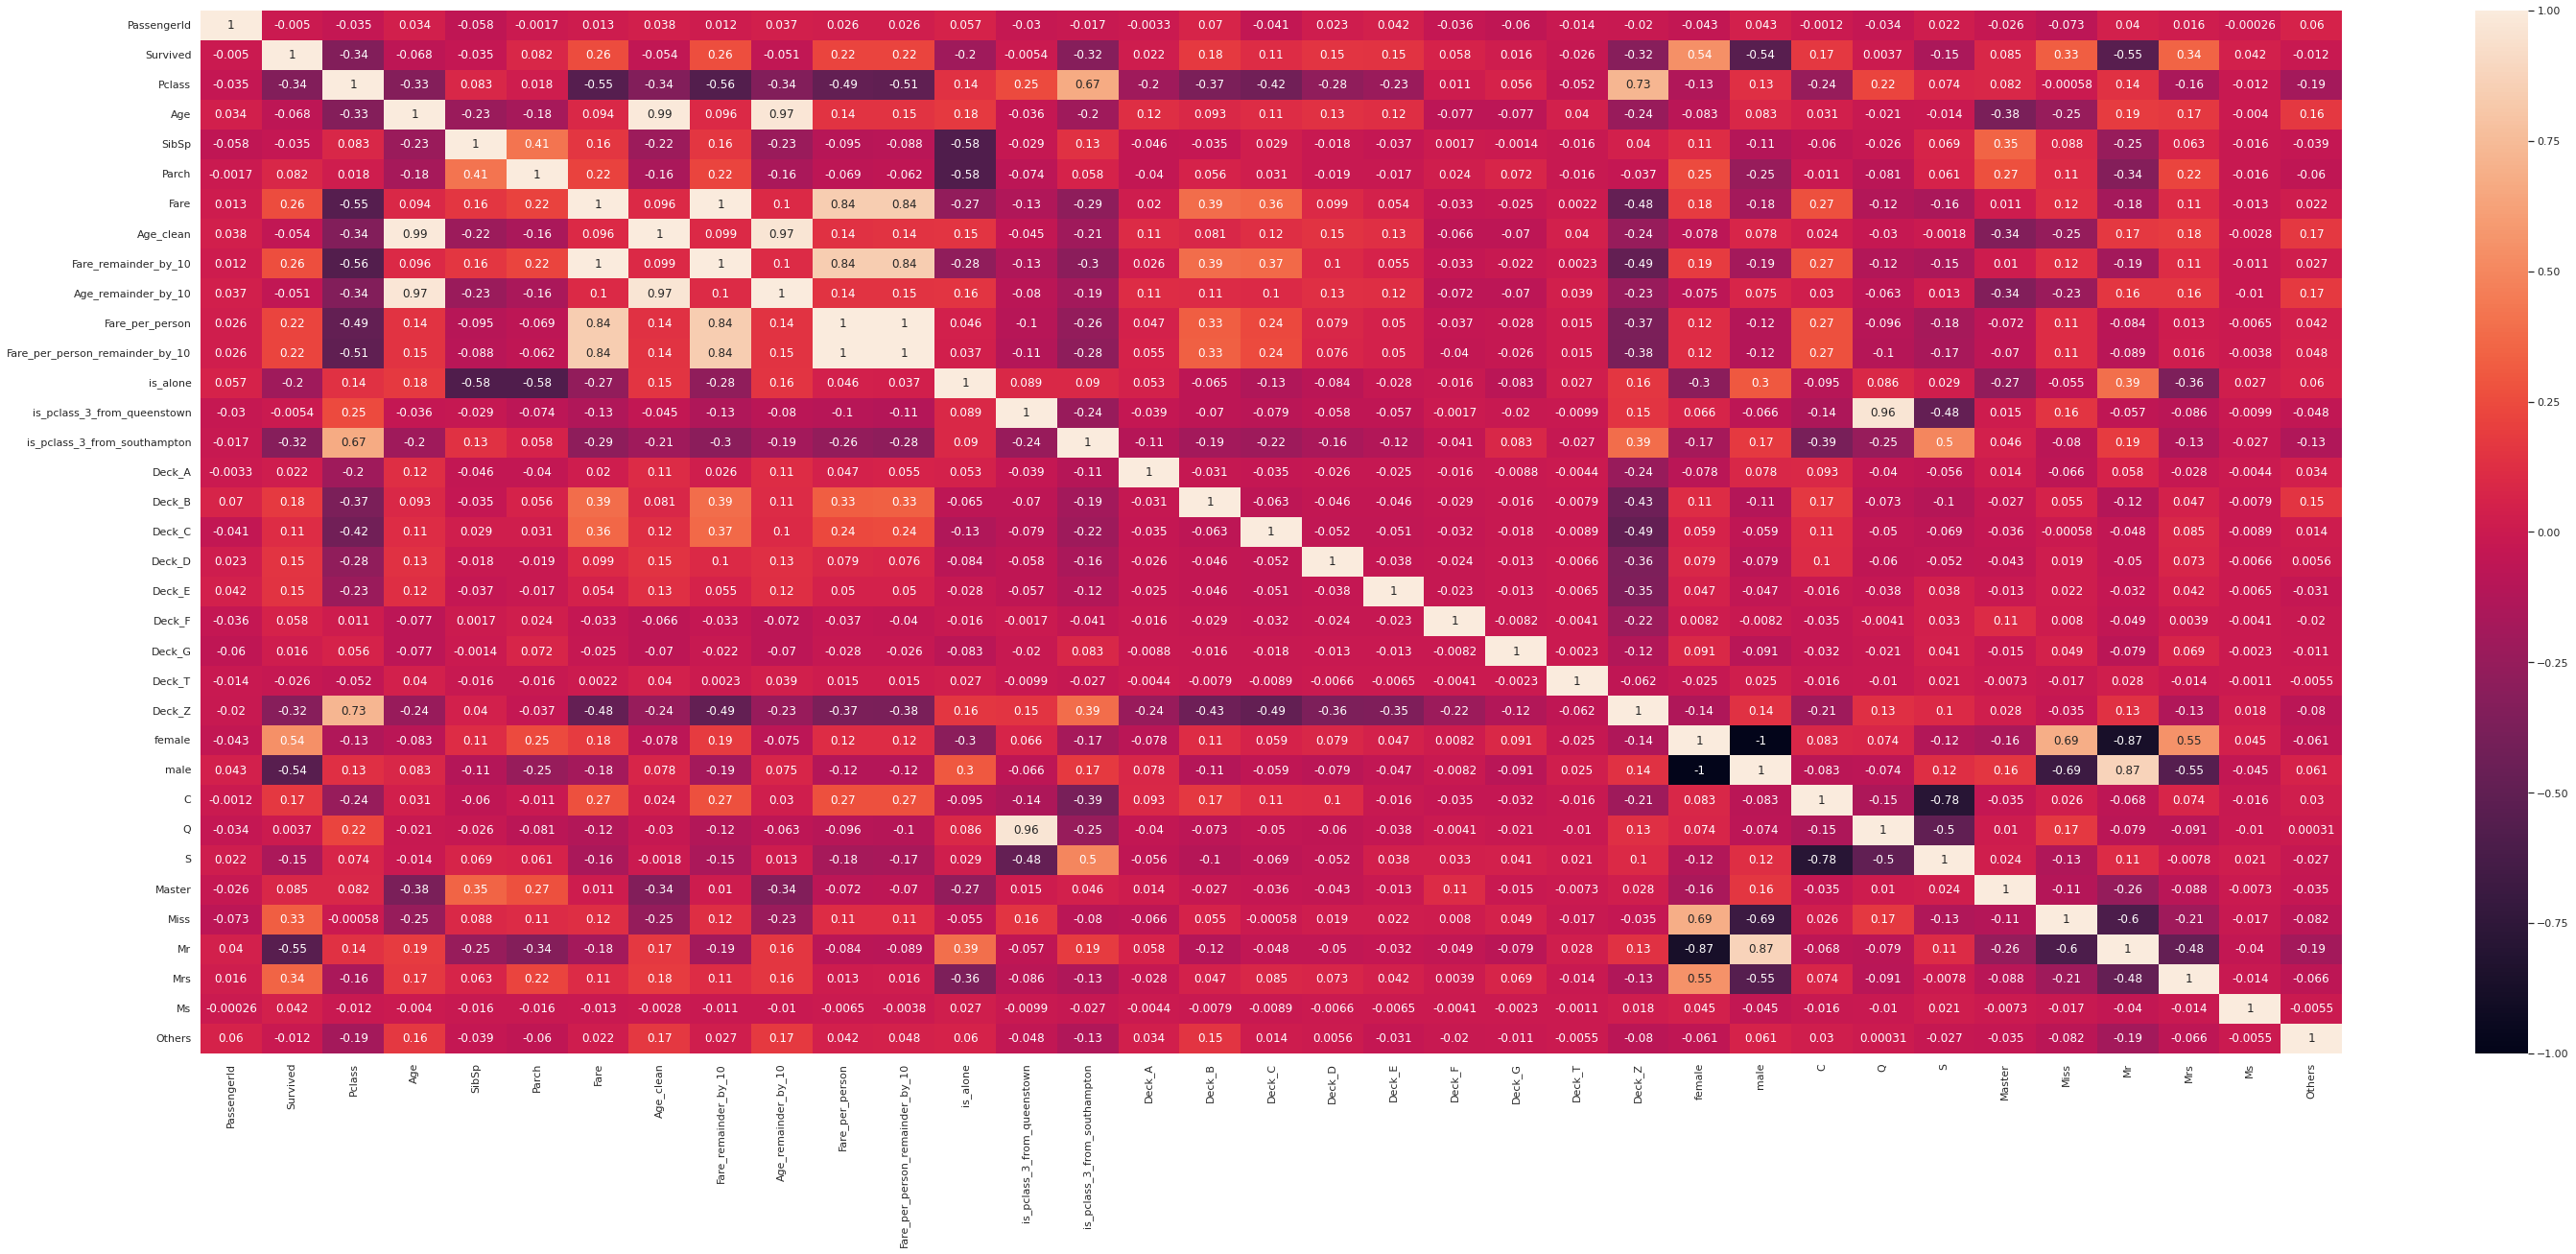

In [24]:
sns.set(rc = {'figure.figsize':(50,20)})
sns.heatmap(dfCorr, annot=True)

In [25]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [26]:
train_input, test_input, train_target, test_target = train_test_split(df[cols], df['Survived'], test_size=0.2, random_state=42)

In [27]:
train_input.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Age_clean,Fare_remainder_by_10,Age_remainder_by_10,Fare_per_person,...,male,C,Q,S,Master,Miss,Mr,Mrs,Ms,Others
331,332,1,45.5,0,0,28.5000,7.0,20.0,40.0,28.500000,...,1,0,0,1,0,0,1,0,0,0
733,734,2,23.0,0,0,13.0000,3.0,10.0,20.0,13.000000,...,1,0,0,1,0,0,1,0,0,0
382,383,3,32.0,0,0,7.9250,5.0,0.0,30.0,7.925000,...,1,0,0,1,0,0,1,0,0,0
704,705,3,26.0,1,0,7.8542,3.0,0.0,20.0,3.927100,...,1,0,0,1,0,0,1,0,0,0
813,814,3,6.0,4,2,31.2750,0.0,30.0,0.0,4.467857,...,0,0,0,1,0,1,0,0,0,0


In [28]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_depth=8, min_samples_split=20, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1, cv=5)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8760552523664169 0.8215896779277061


In [29]:
scores

{'fit_time': array([0.34787107, 0.33567595, 0.34364104, 0.35352373, 0.37106919]),
 'score_time': array([0.04470491, 0.0310092 , 0.0371232 , 0.02468586, 0.03561091]),
 'test_score': array([0.82517483, 0.84615385, 0.81690141, 0.79577465, 0.82394366]),
 'train_score': array([0.87873462, 0.87873462, 0.87192982, 0.87368421, 0.87719298])}

In [30]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.03530843 0.03942081 0.03547258 0.02495221 0.01102696 0.06459351
 0.02315016 0.03818945 0.01805653 0.07572872 0.02370176 0.00625942
 0.00146052 0.05367159 0.00117903 0.00378088 0.00285005 0.00528738
 0.00809507 0.001045   0.00111267 0.01463206 0.11643639 0.14889092
 0.00687966 0.00314206 0.00593205 0.0070015  0.04819064 0.12623959
 0.04682388 0.         0.00148853]


In [31]:
rf.feature_importances_

array([0.03530843, 0.03942081, 0.03547258, 0.02495221, 0.01102696,
       0.06459351, 0.02315016, 0.03818945, 0.01805653, 0.07572872,
       0.02370176, 0.00625942, 0.00146052, 0.05367159, 0.00117903,
       0.00378088, 0.00285005, 0.00528738, 0.00809507, 0.001045  ,
       0.00111267, 0.01463206, 0.11643639, 0.14889092, 0.00687966,
       0.00314206, 0.00593205, 0.0070015 , 0.04819064, 0.12623959,
       0.04682388, 0.        , 0.00148853])

In [32]:
predicted = rf.predict(test_input)
accuracy = accuracy_score(test_target, predicted)

accuracy

0.7988826815642458

In [33]:
df_test = pd.read_csv('./test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [34]:
df_test.loc[df_test['Age'].isnull(), 'Age'] = math.floor(df_test['Age'].mean())
df_test.loc[df_test['Embarked'].isnull(), 'Embarked'] = df_test['Embarked'].mode()[0]
df_test['Deck'] = df_test['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search('Z' if pd.isna(x) else x).group())

df_test.loc[df_test['Fare'].isnull(), 'Fare'] = math.floor(df_test['Fare'].mean())
df_test['Fare_remainder_by_10'] = df_test['Fare'] - (df_test['Fare'] % 10)
df_test['Age_remainder_by_10'] = df_test['Age'] - (df_test['Age'] % 10)


df_test['Title'] = df_test['Name'].replace('Mlle', 'Miss')
df_test['Title'] = df_test['Name'].replace('Ms', 'Miss')
df_test['Title'] = df_test['Name'].replace('Mme', 'Mrs')
df_test['Name_title'] = df_test['Title'].map(lambda x: getNameTitle(x))

df_test['Fare_per_person'] = df_test['Fare'] / (df_test['SibSp'] + df_test['Parch'] + 1)
df_test['Fare_per_person_remainder_by_10'] = df_test['Fare_per_person'] - (df_test['Fare_per_person'] % 10)
df_test['is_alone'] = 1
df_test.loc[df_test['SibSp'] + df_test['Parch'] > 0, 'is_alone'] = 0
df_test['is_pclass_3_from_queenstown'] = 0
df_test.loc[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'Q'), 'is_pclass_3_from_queenstown'] = 1
df_test['is_pclass_3_from_southampton'] = 0
df_test.loc[(df_test['Pclass'] == 3) & (df_test['Embarked'] == 'S'), 'is_pclass_3_from_southampton'] = 1
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
deckDummies = pd.get_dummies(df_test['Deck'], prefix='Deck')
sexDummies = pd.get_dummies(df_test['Sex'])
embarkedDummies = pd.get_dummies(df_test['Embarked'])
nameTitleDummies = pd.get_dummies(df_test['Name_title'])
df_test = pd.concat([df_test, deckDummies, sexDummies, embarkedDummies, nameTitleDummies], axis=1)
df_test = df_test.drop(['Sex', 'Embarked'], axis=1)

In [35]:
df_test.loc[ df_test['Age'] <= 10, 'Age_clean'] = 0
df_test.loc[(df_test['Age'] > 10) & (df_test['Age'] <= 16), 'Age_clean'] = 1
df_test.loc[(df_test['Age'] > 16) & (df_test['Age'] <= 20), 'Age_clean'] = 2
df_test.loc[(df_test['Age'] > 20) & (df_test['Age'] <= 26), 'Age_clean'] = 3
df_test.loc[(df_test['Age'] > 26) & (df_test['Age'] <= 30), 'Age_clean'] = 4
df_test.loc[(df_test['Age'] > 30) & (df_test['Age'] <= 36), 'Age_clean'] = 5
df_test.loc[(df_test['Age'] > 36) & (df_test['Age'] <= 40), 'Age_clean'] = 6
df_test.loc[(df_test['Age'] > 40) & (df_test['Age'] <= 46), 'Age_clean'] = 7
df_test.loc[(df_test['Age'] > 46) & (df_test['Age'] <= 50), 'Age_clean'] = 8
df_test.loc[(df_test['Age'] > 50) & (df_test['Age'] <= 60), 'Age_clean'] = 9
df_test.loc[ df_test['Age'] > 60, 'Age_clean'] = 10

In [36]:
predicted = rf.predict(df_test[cols])
predicted

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [37]:
predictResult = pd.DataFrame(predicted, columns = ['Survived'])
predictResult.head()

,Survived
0,0
1,1
2,0
3,0
4,1


In [38]:
predictDf = pd.concat([df_test['PassengerId'], predictResult['Survived']], axis=1)
predictDf.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [39]:
predictDf.to_csv('./submission.csv', sep=',', index = False)

In [40]:
!kaggle competitions submit -c titanic -f submission.csv -m "Random foreset"

100%|████████████████████████████████████████| 2.77k/2.77k [00:07<00:00, 357B/s]
Successfully submitted to Titanic - Machine Learning from Disaster